[View in Colaboratory](https://colab.research.google.com/github/lgrosjean/deep-learning/blob/master/LeG_Mask_R_CNN.ipynb)

# How to run Object Detection and Segmentation on a Video Fast with Google Colab

Everythings come from : https://www.dlology.com/blog/how-to-run-object-detection-and-segmentation-on-video-fast-for-free/

## Confirm TensorFlow can see the GPU

Simply select "GPU" in the Accelerator drop-down in Notebook Settings (either through the Edit menu or the command palette at cmd/ctrl-shift-P).

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Mount Google drive

It will ask for two verification code during the run.

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

I have access to my Drive now

In [0]:
!ls drive/

## Install pycocotools

In [2]:
!pip install Cython

In [3]:
!ls

assets	cocoapi  LICENSE      mask_rcnn_balloon.h5  mrcnn	      samples
caffe2	datalab  MANIFEST.in  mask_rcnn_coco.h5     README.md	      setup.cfg
coco	images	 Mask_RCNN    Mask-RCNN-series	    requirements.txt  setup.py


In [4]:
!git clone https://github.com/waleedka/coco

fatal: destination path 'coco' already exists and is not an empty directory.


In [5]:
!pip install -U setuptools
!pip install -U wheel
!make install -C coco/PythonAPI

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (39.2.0)
Requirement already up-to-date: wheel in /usr/local/lib/python3.6/dist-packages (0.31.1)
make: Entering directory '/content/coco/PythonAPI'
# install pycocotools to the Python site-packages
python setup.py build_ext install
running build_ext
building 'pycocotools._mask' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
creating build/common
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -Wstrict-prototypes -g -fdebug-prefix-map=/build/python3.6-sXpGnM/python3.6-3.6.3=. -specs=/usr/share/dpkg/no-pie-compile.specs -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/usr/include/python3.6m -c pycocotools/_mask.c -o build/temp.linux-x86_64-3.6/pycocotools/_mask.o -Wno-cpp -Wno-unused-function -std=c99
x86_64-

## Git Clone the code

In [6]:
!git clone https://github.com/matterport/Mask_RCNN

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


## cd to the code directory and optionally download the weights file

In [7]:
import os
os.chdir('./Mask_RCNN')
!git checkout 555126ee899a144ceff09e90b5b2cf46c321200c
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

D	images/1045023827_4ec3e8ba5c_z.jpg
D	images/12283150_12d37e6389_z.jpg
D	images/2383514521_1fc8d7b0de_z.jpg
D	images/2502287818_41e4b0c4fb_z.jpg
D	images/2516944023_d00345997d_z.jpg
D	images/25691390_f9944f61b5_z.jpg
D	images/262985539_1709e54576_z.jpg
D	images/3132016470_c27baa00e8_z.jpg
D	images/3627527276_6fe8cd9bfe_z.jpg
D	images/3651581213_f81963d1dd_z.jpg
D	images/3800883468_12af3c0b50_z.jpg
D	images/3862500489_6fd195d183_z.jpg
D	images/3878153025_8fde829928_z.jpg
D	images/4410436637_7b0ca36ee7_z.jpg
D	images/4782628554_668bc31826_z.jpg
D	images/5951960966_d4e1cda5d0_z.jpg
D	images/6584515005_fce9cec486_z.jpg
D	images/6821351586_59aa0dc110_z.jpg
D	images/7581246086_cf7bbb7255_z.jpg
D	images/7933423348_c30bd9bd4e_z.jpg
D	images/8053677163_d4c8f416be_z.jpg
D	images/8239308689_efa6c11b08_z.jpg
D	images/8433365521_9252889f9a_z.jpg
D	images/8512296263_5fc5458e20_z.jpg
D	images/8699757338_c3941051b6_z.jpg
D	images/8734543718_37f6b8bd45_z.jpg
D	images/8829708882_48f263491e_z.jpg
D	imag

mask_rcnn_coco.h5   100%[===================>] 245.63M  30.5MB/s    in 12s     

2018-06-15 13:35:39 (20.2 MB/s) - ‘mask_rcnn_coco.h5’ saved [257557808/257557808]



In [8]:
!ls

assets	    inspect_data.ipynb	   model.py	      train_shapes.ipynb
coco.py     inspect_model.ipynb    parallel_model.py  utils.py
config.py   inspect_weights.ipynb  README.md	      visualize.py
demo.ipynb  LICENSE		   samples
drive	    mask_rcnn_coco.h5	   shapes.py


# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [9]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import coco
import utils
import model as modellib
import visualize

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [10]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENC

## Create Model and Load Trained Weights

In [0]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [0]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

Processing 1 images
image                    shape: (607, 1080, 3)        min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1080.00000


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


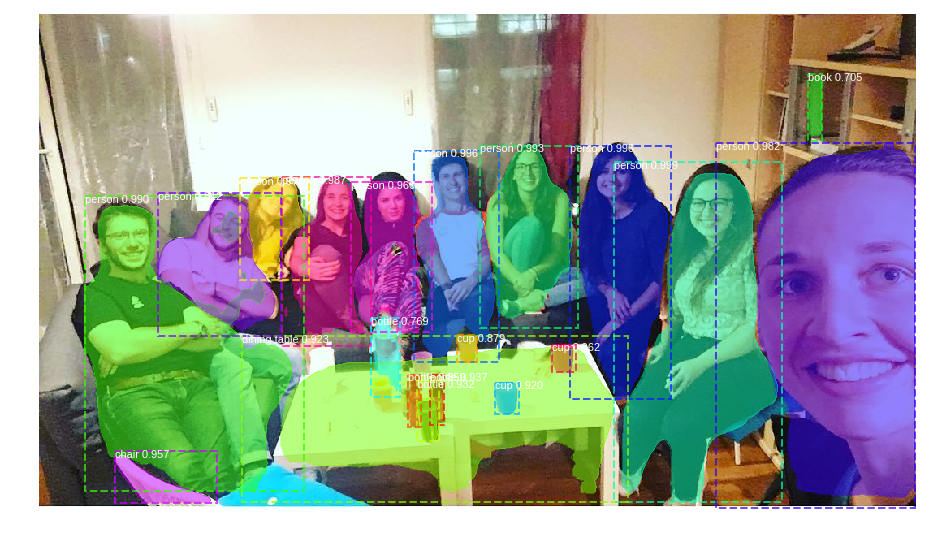

In [17]:
# Load a random image from the images folder
file_name = "hajar.khairallah_BZUU-S5n5b9.jpg"
image = skimage.io.imread(os.path.join("drive", file_name))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

## Process Video
Download the video mp4 file.

In [46]:
import cv2
import numpy as np


def random_colors(N):
    np.random.seed(1)
    colors = [tuple(255 * np.random.rand(3)) for _ in range(N)]
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """apply mask to image"""
    for n, c in enumerate(color):
        image[:, :, n] = np.where(
            mask == 1,
            image[:, :, n] * (1 - alpha) + alpha * c,
            image[:, :, n]
        )
    return image


def display_instances(image, boxes, masks, ids, names, scores):
    """
        take the image and results and apply the mask, box, and Label
    """
    n_instances = boxes.shape[0]
    colors = random_colors(n_instances)

    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i, color in enumerate(colors):
        if not np.any(boxes[i]):
            continue

        y1, x1, y2, x2 = boxes[i]
        label = names[ids[i]]
        score = scores[i] if scores is not None else None
        caption = '{} {:.2f}'.format(label, score) if score else label
        mask = masks[:, :, i]

        image = apply_mask(image, mask, color)
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        image = cv2.putText(
            image, caption, (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.7, color, 2
        )

    return image


if __name__ == '__main__':
    """
        test everything
    """
    import os
    import sys
    import coco
    import utils
    import model as modellib
    
    # We use a K80 GPU with 24GB memory, which can fit 3 images.
    batch_size = 3

    ROOT_DIR = os.getcwd()
    MODEL_DIR = os.path.join(ROOT_DIR, "logs")
    DRIVE_DIR = "drive"
    VIDEO_DIR = os.path.join(DRIVE_DIR, "videos")
    VIDEO_SAVE_DIR = os.path.join(VIDEO_DIR, "save")
    COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
    if not os.path.exists(COCO_MODEL_PATH):
        utils.download_trained_weights(COCO_MODEL_PATH)

    class InferenceConfig(coco.CocoConfig):
        GPU_COUNT = 1
        IMAGES_PER_GPU = batch_size

    config = InferenceConfig()
    config.display()

    model = modellib.MaskRCNN(
        mode="inference", model_dir=MODEL_DIR, config=config
    )
    model.load_weights(COCO_MODEL_PATH, by_name=True)
    class_names = [
        'BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
        'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
        'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
        'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
        'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
        'kite', 'baseball bat', 'baseball glove', 'skateboard',
        'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
        'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
        'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
        'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
        'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
        'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
        'teddy bear', 'hair drier', 'toothbrush'
    ]

    capture = cv2.VideoCapture(os.path.join(VIDEO_DIR, 'video-test.avi'))
    try:
        if not os.path.exists(VIDEO_SAVE_DIR):
            os.makedirs(VIDEO_SAVE_DIR)
    except OSError:
        print ('Error: Creating directory of data')
    frames = []
    frame_count = 0
    # these 2 lines can be removed if you dont have a 1080p camera.
    capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
    capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

    while True:
        ret, frame = capture.read()
        # Bail out when the video file ends
        if not ret:
            break
        
        # Save each frame of the video to a list
        frame_count += 1
        frames.append(frame)
        #print('frame_count :{0}'.format(frame_count))
        if len(frames) == batch_size:
            results = model.detect(frames, verbose=0)
            #print('Predicted')
            for i, item in enumerate(zip(frames, results)):
                frame = item[0]
                r = item[1]
                frame = display_instances(
                    frame, r['rois'], r['masks'], r['class_ids'], class_names, r['scores']
                )
                name = '{0}.jpg'.format(frame_count + i - batch_size)
                name = os.path.join(VIDEO_SAVE_DIR, name)
                cv2.imwrite(name, frame)
                print('writing to file:{0}'.format(name))
            # Clear the frames array to start the next batch
            frames = []

    capture.release()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     3
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 3
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENC

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Predicted
writing to file:drive/videos/save/0.jpg
writing to file:drive/videos/save/1.jpg
writing to file:drive/videos/save/2.jpg
frame_count :4
frame_count :5
frame_count :6
Predicted
writing to file:drive/videos/save/3.jpg
writing to file:drive/videos/save/4.jpg
writing to file:drive/videos/save/5.jpg
frame_count :7
frame_count :8
frame_count :9
Predicted
writing to file:drive/videos/save/6.jpg
writing to file:drive/videos/save/7.jpg
writing to file:drive/videos/save/8.jpg
frame_count :10
frame_count :11
frame_count :12
Predicted
writing to file:drive/videos/save/9.jpg
writing to file:drive/videos/save/10.jpg
writing to file:drive/videos/save/11.jpg
frame_count :13
frame_count :14
frame_count :15
Predicted
writing to file:drive/videos/save/12.jpg
writing to file:drive/videos/save/13.jpg
writing to file:drive/videos/save/14.jpg
frame_count :16
frame_count :17
frame_count :18
Predicted
writing to file:drive/videos/save/15.jpg
writing to file:drive/videos/save/16.jpg
writing to file:dri

writing to file:drive/videos/save/49.jpg
writing to file:drive/videos/save/50.jpg
frame_count :52
frame_count :53
frame_count :54
Predicted
writing to file:drive/videos/save/51.jpg
writing to file:drive/videos/save/52.jpg
writing to file:drive/videos/save/53.jpg
frame_count :55
frame_count :56
frame_count :57
Predicted
writing to file:drive/videos/save/54.jpg
writing to file:drive/videos/save/55.jpg
writing to file:drive/videos/save/56.jpg
frame_count :58
frame_count :59
frame_count :60
Predicted
writing to file:drive/videos/save/57.jpg
writing to file:drive/videos/save/58.jpg
writing to file:drive/videos/save/59.jpg
frame_count :61
frame_count :62
frame_count :63
Predicted
writing to file:drive/videos/save/60.jpg
writing to file:drive/videos/save/61.jpg
writing to file:drive/videos/save/62.jpg
frame_count :64
frame_count :65
frame_count :66
Predicted
writing to file:drive/videos/save/63.jpg
writing to file:drive/videos/save/64.jpg
writing to file:drive/videos/save/65.jpg
frame_count :

In [47]:
! ls ./drive/videos/save

0.jpg	19.jpg	28.jpg	37.jpg	46.jpg	55.jpg	64.jpg	73.jpg	82.jpg	91.jpg
10.jpg	1.jpg	29.jpg	38.jpg	47.jpg	56.jpg	65.jpg	74.jpg	83.jpg	92.jpg
11.jpg	20.jpg	2.jpg	39.jpg	48.jpg	57.jpg	66.jpg	75.jpg	84.jpg	9.jpg
12.jpg	21.jpg	30.jpg	3.jpg	49.jpg	58.jpg	67.jpg	76.jpg	85.jpg
13.jpg	22.jpg	31.jpg	40.jpg	4.jpg	59.jpg	68.jpg	77.jpg	86.jpg
14.jpg	23.jpg	32.jpg	41.jpg	50.jpg	5.jpg	69.jpg	78.jpg	87.jpg
15.jpg	24.jpg	33.jpg	42.jpg	51.jpg	60.jpg	6.jpg	79.jpg	88.jpg
16.jpg	25.jpg	34.jpg	43.jpg	52.jpg	61.jpg	70.jpg	7.jpg	89.jpg
17.jpg	26.jpg	35.jpg	44.jpg	53.jpg	62.jpg	71.jpg	80.jpg	8.jpg
18.jpg	27.jpg	36.jpg	45.jpg	54.jpg	63.jpg	72.jpg	81.jpg	90.jpg


In [48]:
video = cv2.VideoCapture(os.path.join(VIDEO_DIR, 'video-test.avi'));

# Find OpenCV version
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

if int(major_ver)  < 3 :
    fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
else :
    fps = video.get(cv2.CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))

video.release();

Frames per second using video.get(cv2.CAP_PROP_FPS) : 20.0


In [49]:
def make_video(outvid, images=None, fps=30, size=None,
               is_color=True, format="FMP4"):
    """
    Create a video from a list of images.
 
    @param      outvid      output video
    @param      images      list of images to use in the video
    @param      fps         frame per second
    @param      size        size of each frame
    @param      is_color    color
    @param      format      see http://www.fourcc.org/codecs.php
    @return                 see http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
 
    The function relies on http://opencv-python-tutroals.readthedocs.org/en/latest/.
    By default, the video will have the size of the first image.
    It will resize every image to this size before adding them to the video.
    """
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.exists(image):
            raise FileNotFoundError(image)
        img = imread(image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid

import glob
import os

# Directory of images to run detection on
#ROOT_DIR = os.getcwd()
#VIDEO_DIR = os.path.join(ROOT_DIR, "videos")
#VIDEO_SAVE_DIR = os.path.join(VIDEO_DIR, "save")
images = list(glob.iglob(os.path.join(VIDEO_SAVE_DIR, '*.*')))
# Sort the images by integer index
images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))

outvid = os.path.join(VIDEO_DIR, "out.mp4")
make_video(outvid, images, fps=30)

<VideoWriter 0x7f09202f3130>

In [50]:
!ls -alh ./drive/videos/

total 3.3M
drwxr-xr-x 2 root root 4.0K Jun 15 13:17 .
drwxr-xr-x 2 root root 4.0K Jun 15 13:13 ..
-rw-r--r-- 1 root root 1.7M Jun 15 14:01 out.mp4
drwxr-xr-x 2 root root 4.0K Jun 15 13:18 save
-rw-r--r-- 1 root root 1.6M Jun 15 13:05 video-test.avi


### Downlod the output video to our local machine

In [0]:
from google.colab import files
files.download('drive/videos/out.mp4')

### Converting video into GIF

In [53]:
! pip install MoviePy

    100% |████████████████████████████████| 378kB 20.1MB/s 
    100% |████████████████████████████████| 3.3MB 6.2MB/s 
    100% |████████████████████████████████| 51kB 18.6MB/s 
  Running setup.py bdist_wheel for MoviePy ... - \ done
  Stored in directory: /content/.cache/pip/wheels/ad/92/4d/a6c6307d4c2219d002646bd4a5987e31fd5697f6ea7778b2c0
Successfully built MoviePy


In [57]:
from moviepy.editor import *

clip = (VideoFileClip("drive/videos/out.mp4")
        #.subclip((1,22.65),(1,23.2))
        #.resize(0.3)
       )
clip.write_gif("drive/videos/out.gif")


[MoviePy] Building file drive/videos/out.gif with imageio


 99%|█████████▉| 93/94 [00:27<00:00,  3.36it/s]


In [58]:
from IPython.display import Image
from IPython.display import display
display(Image(url='drive/videos/out.gif'))